In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
(train_ds, valid_ds, test_ds), info_ds = tfds.load(
    'oxford_iiit_pet', split=['train', 'test[50:]', 'test[:50]'], 
    as_supervised=False, with_info=True, data_dir='data/'
)

In [3]:
index_label = dict([(index, label) for index, label in enumerate(info_ds.features['label'].names)])

# EDA
- Visualize image and mask

In [4]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    label = images['title']
    for i, (name, image) in enumerate(images.items()):
        if name != 'title':
            plt.subplot(1, n, i + 1)
            plt.title(name + "_" + label.lower())
            plt.xticks([])
            plt.yticks([])
            plt.imshow(image)
    plt.show()

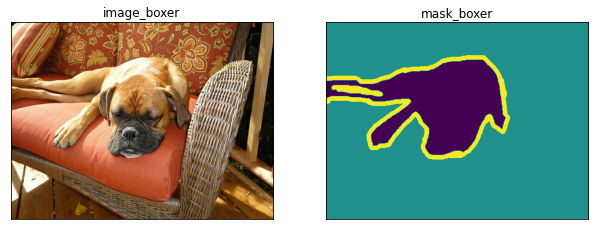

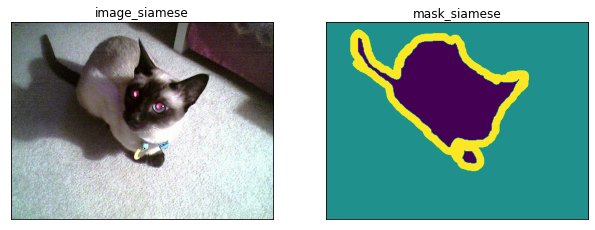

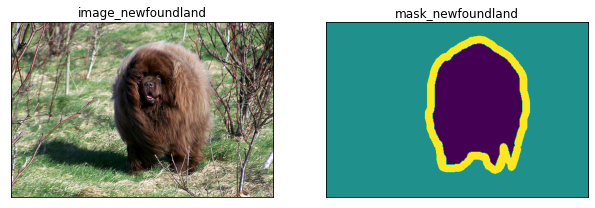

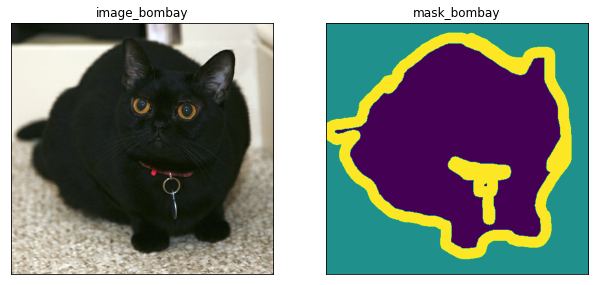

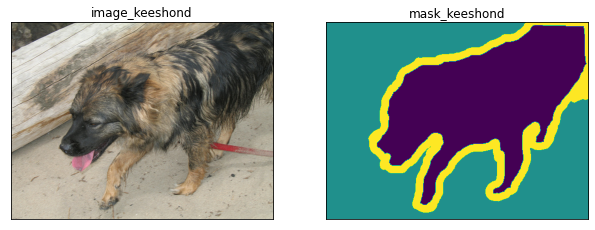

In [5]:
for data in train_ds.shuffle(1024).take(5):
    visualize(
        title=index_label[data['label'].numpy()], image=data['image'], mask=data['segmentation_mask']
    )

# Image Mapping
- Resize image and mask

In [6]:
@tf.function
def norm_image(data):
    image, mask = data['image'], data['segmentation_mask']
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    mask = tf.image.resize(mask, [256, 256])
    
    image = image / 255.
    mask -= 1
    return image, mask 

In [7]:
train_ds = train_ds.shuffle(len(train_ds)).map(norm_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(norm_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

# Model building

In [8]:
input_layer = tf.keras.layers.Input(shape=(256, 256, 3))

# First layer
c1 = tf.keras.layers.Conv2D(64, activation='relu', padding='same', kernel_size=3)(input_layer)
c1 = tf.keras.layers.Conv2D(64, activation='relu', padding='same', kernel_size=3)(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# Second layer
c2 = tf.keras.layers.Conv2D(128, activation='relu', padding='same', kernel_size=3)(p1)
c2 = tf.keras.layers.Conv2D(128, activation='relu', padding='same', kernel_size=3)(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# Third layer
c3 = tf.keras.layers.Conv2D(256, activation='relu', padding='same', kernel_size=3)(p2)
c3 = tf.keras.layers.Conv2D(256, activation='relu', padding='same', kernel_size=3)(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# Fourth layer
c4 = tf.keras.layers.Conv2D(512, activation='relu', padding='same', kernel_size=3)(p3)
c4 = tf.keras.layers.Conv2D(512, activation='relu', padding='same', kernel_size=3)(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# Final layer
c5 = tf.keras.layers.Conv2D(1024, activation='relu', padding='same', kernel_size=3)(p4)
c5 = tf.keras.layers.Conv2D(1024, activation='relu', padding='same', kernel_size=3)(c5)

# Upsampling layer
up6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
merge6 = tf.keras.layers.concatenate([c4, up6], axis=3)
c6 = tf.keras.layers.Conv2D(512, activation='relu', padding='same', kernel_size=3)(merge6)
c6 = tf.keras.layers.Conv2D(512, activation='relu', padding='same', kernel_size=3)(c6)

up7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
merge7 = tf.keras.layers.concatenate([c3, up7], axis=3)
c7 = tf.keras.layers.Conv2D(256, activation='relu', padding='same', kernel_size=3)(merge7)
c7 = tf.keras.layers.Conv2D(256, activation='relu', padding='same', kernel_size=3)(c7)

up8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
merge8 = tf.keras.layers.concatenate([c2, up8], axis=3)
c8 = tf.keras.layers.Conv2D(128, activation='relu', padding='same', kernel_size=3)(merge8)
c8 = tf.keras.layers.Conv2D(128, activation='relu', padding='same', kernel_size=3)(c8)

up9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
merge9 = tf.keras.layers.concatenate([c1, up9], axis=3)
c9 = tf.keras.layers.Conv2D(64, activation='relu', padding='same', kernel_size=3)(merge9)
c9 = tf.keras.layers.Conv2D(64, activation='relu', padding='same', kernel_size=3)(c9)
c10 = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(c9)

In [9]:
model = tf.keras.Model(inputs=input_layer, outputs=c10)

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

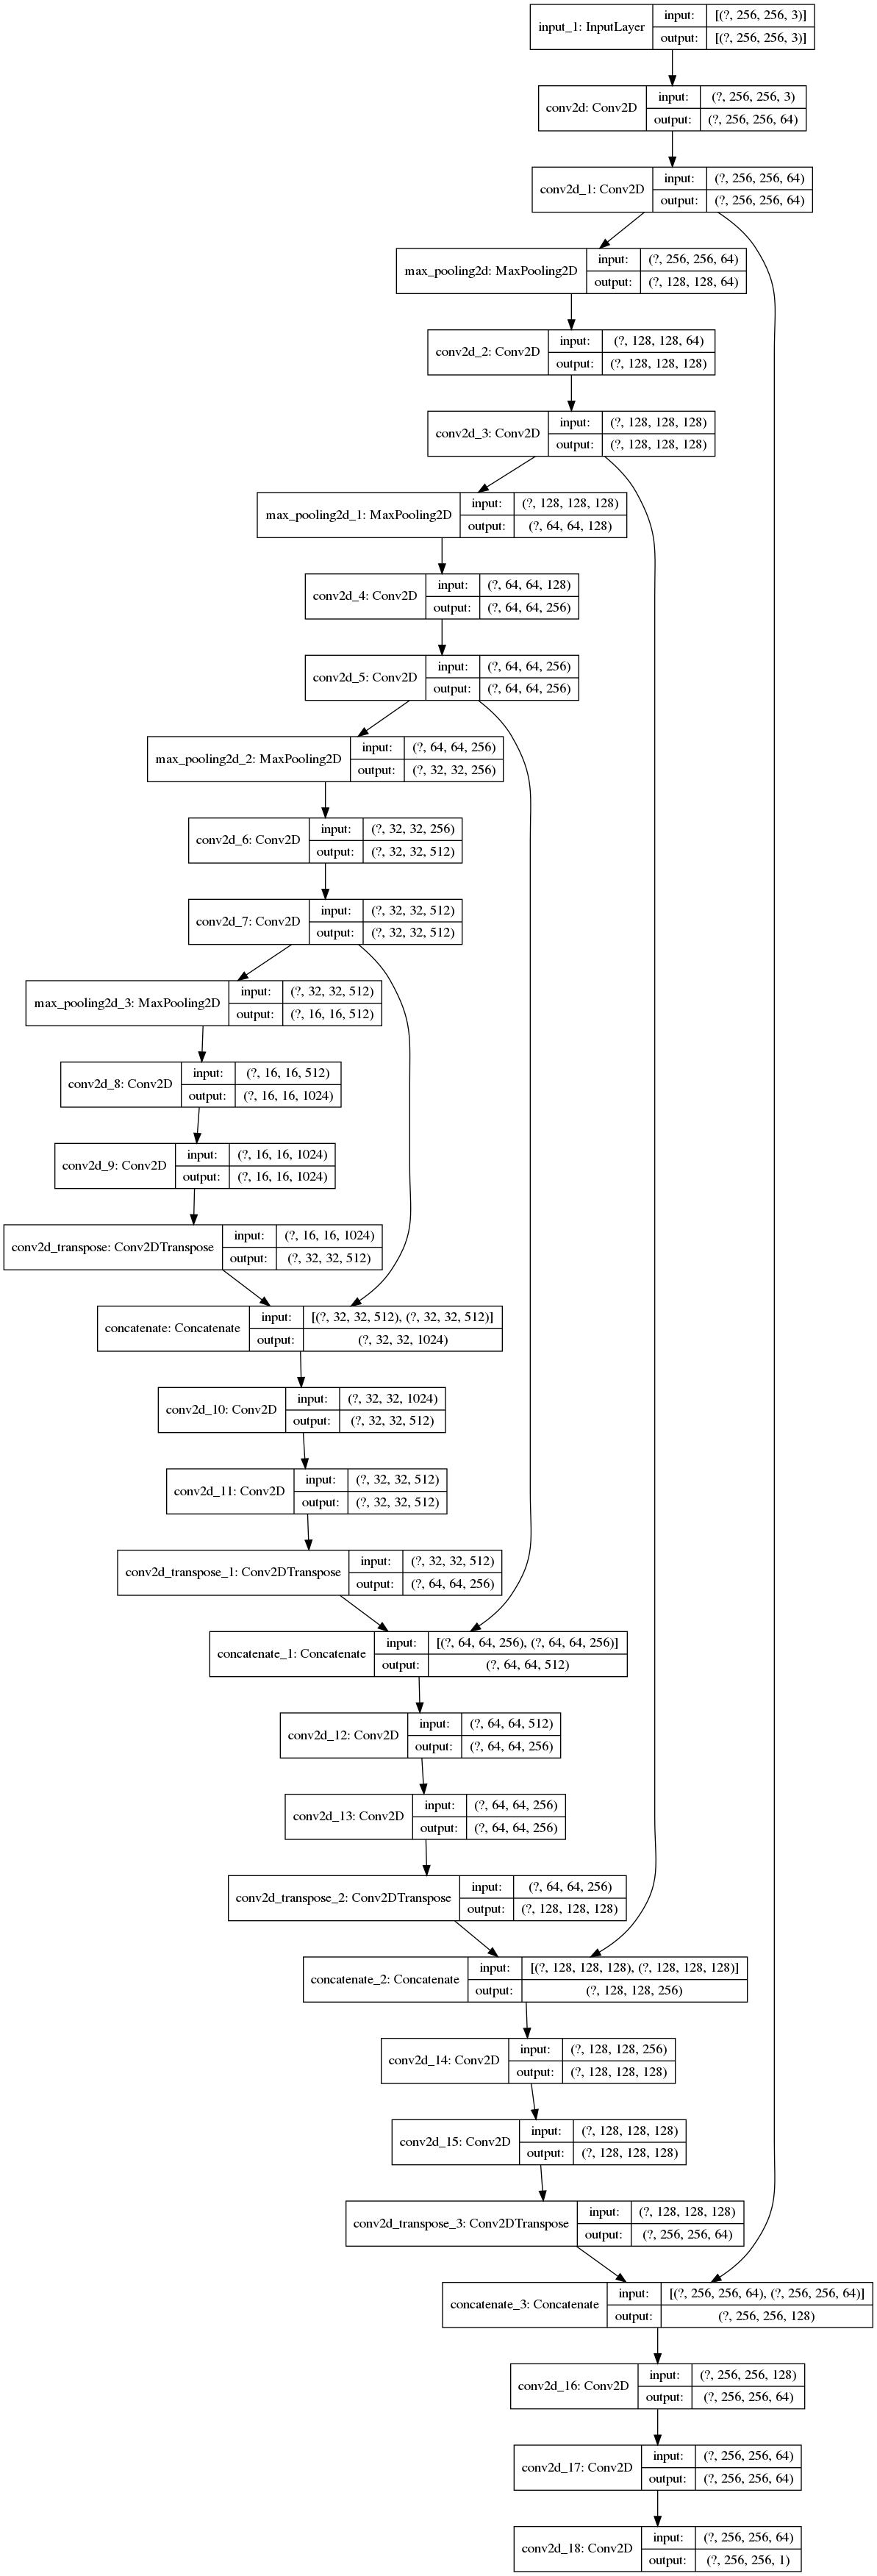

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Training

In [12]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=10)

Epoch 1/10
  2/230 [..............................] - ETA: 1:01 - loss: 0.5579 - accuracy: 0.2845WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1612s vs `on_train_batch_end` time: 0.3732s). Check your callbacks.


230/230 [==============================] - 155s 675ms/step - loss: 0.5038 - accuracy: 0.5781 - val_loss: 0.4900 - val_accuracy: 0.5732
Epoch 2/10
215/230 [===========================>..] - ETA: 7s - loss: 0.4986 - accuracy: 0.5822